# Monad pipeline
For BP purposes

Norbert Matuška

In [1]:
import pandas as pd
import numpy as np
import base64
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

Decodes and parses 802.11 wireless frame headers, extracting details like frame type, MAC addresses, and sequence information. It categorizes management, control, and data frames.

In [2]:
def decode_header(header):
    try:
        return base64.b64decode(header)
    except Exception as e:
        print(f"Error decoding header: {e}")
        return None

def translate_header(header):
    try:
        # frame control
        frame_control_raw = int.from_bytes(header[:2], byteorder="little")
        protocol_version = frame_control_raw & 0b11  # 0-1
        frame_type = (frame_control_raw >> 2) & 0b11  # 2-3
        subtype = (frame_control_raw >> 4) & 0b1111  # 4-7
        flags = (frame_control_raw >> 8) & 0xFF  # 8-15
    
        frame_type_map = {
            0: "Management",
            1: "Control",
            2: "Data",
        }
        management_subtypes = {
            0: "Association Request",
            1: "Association Response",
            2: "Reassociation Request",
            3: "Reassociation Response",
            4: "Probe Request",
            5: "Probe Response",
            8: "Beacon",
            9: "ATIM",
            10: "Disassociation",
            11: "Authentication",
            12: "Deauthentication",
            14: "Action",
        }
        control_subtypes = {
            10: "PS-Poll",
            11: "RTS",
            12: "CTS",
            13: "ACK",
            14: "CF-End",
            15: "CF-End + CF-Ack",
        }
        data_subtypes = {
            0: "Data",
            1: "Data + CF-Ack",
            2: "Data + CF-Poll",
            3: "Data + CF-Ack + CF-Poll",
            4: "Null Function (No Data)",
            6: "QoS Data",
        }
    
        type_description = frame_type_map.get(frame_type, "Reserved")
        subtype_description = None
        if frame_type == 0:  # management
            subtype_description = management_subtypes.get(subtype, "Unknown")
        elif frame_type == 1:  # control
            subtype_description = control_subtypes.get(subtype, "Unknown")
        elif frame_type == 2:  # data
            subtype_description = data_subtypes.get(subtype, "Unknown")
    
        duration_id = int.from_bytes(header[2:4], byteorder="little")
        destination_mac = ":".join(f"{byte:02x}" for byte in header[4:10])
        source_mac = ":".join(f"{byte:02x}" for byte in header[10:16])
        bssid_mac = ":".join(f"{byte:02x}" for byte in header[16:22])
        sequence_control = int.from_bytes(header[22:24], byteorder="little")
        fragment_number = sequence_control & 0b1111  # last 4 bits
        sequence_number = (sequence_control >> 4) & 0xFFF  # first 12 bits
        
        # remainder
        frame_body = header[24:]
    
        return [
            frame_control_raw, protocol_version, type_description, subtype_description, flags,
            duration_id, destination_mac, source_mac, bssid_mac,
            sequence_control, fragment_number, sequence_number, frame_body
        ]
    except Exception as e:
        print(f"Error translating header: {e}")
        return [None] * 13

TRANSLATED_HEADER_COLUMNS = [
    "frame_control_raw", "protocol_version", "type", "subtype", "flags",
    "duration_id", "destination_mac", "source_mac", "bssid_mac",
    "sequence_control_raw", "fragment_number", "sequence_number", "frame_body"
]

Processes a large CSV file in chunks, decoding and translating headers, then combines the results into a final DataFrame for analysis.

In [3]:
data = []
translated_headers = []
for chunk in pd.read_csv("D:/monadcount_l2pk_v2_10000000.csv", chunksize=100000):
    chunk["decoded_headers"] = chunk["header"].apply(decode_header)
    chunk_translated = chunk["decoded_headers"].apply(translate_header)
    translated_chunk_df = pd.DataFrame(chunk_translated.tolist(), columns=TRANSLATED_HEADER_COLUMNS)

    data.append(chunk)
    translated_headers.append(translated_chunk_df)

data_df = pd.concat(data, ignore_index=True)
translated_df = pd.DataFrame(pd.concat(translated_headers, ignore_index=True))

data_df = pd.concat([data_df, translated_df], axis=1)
data_df

,device,uploaded_file_id,happened_at,rssi,channel,header,payload,id,decoded_headers,frame_control_raw,...,subtype,flags,duration_id,destination_mac,source_mac,bssid_mac,sequence_control_raw,fragment_number,sequence_number,frame_body
0,CC:7B:5C:27:9E:30,1772,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQNTY/T9YDPw/YUIYgIBH,cMP9PwEAAAAgDAYAYEf9P+Qy/T/AR/0/AQAAAAAAAAA8sg...,941936cf-bcb5-49ae-ab39-eee55264d748,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,16381,...,None,63,1,00:00:00:00:00:00,00:00:00:00:00:00,00:00:54:59:08:40,55508,4,3469,b'\xfd?X\x0c\xfc?aB\x18\x80\x80G'
1,CC:7B:5C:27:9E:30,1772,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAB8w/0/iMr9P4Dh/T9YDPw/YUIYgIBH,fMP9PwEAAAAgDQYAYEf9P+Qy/T/AR/0/AQAAAAAAAABWtQ...,da58e9ab-1131-43f6-91ae-0bc6568e5f0f,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,16381,...,None,63,1,00:00:00:00:00:00,00:00:00:00:7c:c3,fd:3f:88:ca:fd:3f,57728,0,3608,b'\xfd?X\x0c\xfc?aB\x18\x80\x80G'
2,CC:7B:5C:27:9E:30,1772,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQAhK/T9YDPw/YUIYgIBH,iMP9PwEAAAAgBwYAYEf9P+Qy/T/AR/0/AQAAAAAAAABHuA...,83e3b38b-8d15-4eea-ac6c-01933ac8e38d,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,16381,...,None,63,1,00:00:00:00:00:00,00:00:00:00:00:00,00:00:54:59:08:40,18952,8,1184,b'\xfd?X\x0c\xfc?aB\x18\x80\x80G'
3,CC:7B:5C:27:9E:30,2215,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQNTY/T9YDPw/YUIYgIBH,cMP9PwEAAAAgBwYAYEf9P+Qy/T/AR/0/AQAAAAAAAABU8Q...,44c5dd36-2719-4c40-b5c4-cc64f77bbe61,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,16381,...,None,63,1,00:00:00:00:00:00,00:00:00:00:00:00,00:00:54:59:08:40,55508,4,3469,b'\xfd?X\x0c\xfc?aB\x18\x80\x80G'
4,CC:7B:5C:27:9E:30,2215,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQIDh/T9YDPw/YUIYgIBH,fMP9PwEAAAAgBwYAYEf9P+Qy/T/AR/0/AQAAAAAAAABY8g...,d2aa9202-5f57-4a62-a455-8ea35cf93604,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,16381,...,None,63,1,00:00:00:00:00:00,00:00:00:00:00:00,00:00:54:59:08:40,57728,0,3608,b'\xfd?X\x0c\xfc?aB\x18\x80\x80G'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,CC:7B:5C:27:9E:30,2530,2024-12-04 10:30:39,-76,4,QAAAAP///////3DNDbbYsf///////wAaAAABCAIECxYMEhgk,MgQwSGBsLRrnCRf//wAAAAAAAAAAAAAAAAAAAAAAAAAAAH...,0dcdd881-abab-435f-95e6-336d4d671627,b'@\x00\x00\x00\xff\xff\xff\xff\xff\xffp\xcd\r...,64,...,Probe Request,0,0,ff:ff:ff:ff:ff:ff,70:cd:0d:b6:d8:b1,ff:ff:ff:ff:ff:ff,6656,0,416,b'\x00\x00\x01\x08\x02\x04\x0b\x16\x0c\x12\x18$'
9999996,CC:7B:5C:27:9E:30,2530,2024-12-04 10:30:39,-51,4,QAAAAP///////4y4fmCcU////////1C3AAABCAIECxYMEhgk,MgQwSGBsAwEFLRrvGRf//wAAAAAAAAAALAEBAAAAAAAAAA...,51ddbd22-0afd-4346-8828-ef73f649bd9c,b'@\x00\x00\x00\xff\xff\xff\xff\xff\xff\x8c\xb...,64,...,Probe Request,0,0,ff:ff:ff:ff:ff:ff,8c:b8:7e:60:9c:53,ff:ff:ff:ff:ff:ff,46928,0,2933,b'\x00\x00\x01\x08\x02\x04\x0b\x16\x0c\x12\x18$'
9999997,CC:7B:5C:27:9E:30,2530,2024-12-04 10:30:39,-55,4,QAAAAP///////4y4fmCcU////////2C3AAABCAIECxYMEhgk,MgQwSGBsAwEGLRrvGRf//wAAAAAAAAAALAEBAAAAAAAAAA...,7c92f383-1dd4-4f02-adef-b1e8e440f235,b'@\x00\x00\x00\xff\xff\xff\xff\xff\xff\x8c\xb...,64,...,Probe Request,0,0,ff:ff:ff:ff:ff:ff,8c:b8:7e:60:9c:53,ff:ff:ff:ff:ff:ff,46944,0,2934,b'\x00\x00\x01\x08\x02\x04\x0b\x16\x0c\x12\x18$'
9999998,CC:7B:5C:27:9E:30,2530,2024-12-04 10:30:39,-53,4,QAAAAP///////9YHTe8Owv///////1BTAAABBIKEi5YyCAwS,GCQwSGBsAwEFLRotQBv//wAAAAAAAAAAAAAAAAAAAAAAAA...,7497cd60-4a0a-4af5-bc32-3cef2ef2f44c,b'@\x00\x00\x00\xff\xff\xff\xff\xff\xff\xd6\x0...,64,...,Probe Request,0,0,ff:ff:ff:ff:ff:ff,d6:07:4d:ef:0e:c2,ff:ff:ff:ff:ff:ff,21328,0,1333,b'\x00\x00\x01\x04\x82\x84\x8b\x962\x08\x0c\x12'


Function identifies static devices based on RSSI variance, grouping packets by src_MAC. Devices with consistently low RSSI variance across sniffers are classified as static.
-- needs another condition

In [4]:
def detect_static_devices(datadf, rssi_threshold=1, chunksize=100000):
    aggregator = {}

    for start in range(0, len(datadf), chunksize):
        chunk = datadf.iloc[start : start + chunksize]
        # group by source_mac in the current chunk
        for source_mac, group in chunk.groupby("source_mac"):
            # if first time seeing MAC
            if source_mac not in aggregator:
                aggregator[source_mac] = {
                    "sniffer_rssi": defaultdict(list),
                    "sniffer_packet_count": defaultdict(int),
                    "total_packet_count": 0
                }
            
            # now group by sniffer in this chunk
            for sniffer_id, sniffer_group in group.groupby("device"):
                rssi_vals = sniffer_group["rssi"].tolist()
                aggregator[source_mac]["sniffer_rssi"][sniffer_id].extend(rssi_vals)
                aggregator[source_mac]["sniffer_packet_count"][sniffer_id] += len(rssi_vals)
            
            aggregator[source_mac]["total_packet_count"] += len(group)

    static_devices = []
    for source_mac, data in aggregator.items():
        sniffer_rssi = data["sniffer_rssi"]
        sniffer_packet_count = data["sniffer_packet_count"]
        total_packets = data["total_packet_count"]

        sniffer_variances = {}
        all_below_threshold = True
        max_variance = 0.0

        for sniffer_id, rssi_values in sniffer_rssi.items():
            variance = pd.Series(rssi_values).var()
            sniffer_variances[sniffer_id] = variance
            if pd.isna(variance) or variance >= rssi_threshold:
                all_below_threshold = False
                break
            if variance > max_variance:
                max_variance = variance

        if all_below_threshold:            
            detected_by_device = ",".join(sniffer_rssi.keys())
            static_devices.append({
                "source_mac": source_mac,
                "rssi_variance": max_variance,
                "detected_by_device": detected_by_device,
                "packet_count": total_packets,
            })
    return pd.DataFrame(static_devices)


static_devices = detect_static_devices(data_df)
static_devices

,source_mac,rssi_variance,detected_by_device,packet_count
0,00:00:00:00:00:00,0.000000,CC:7B:5C:27:9E:30,9
1,02:51:8a:83:00:a5,0.000000,CC:7B:5C:27:9E:30,3
2,0e:2e:f8:46:bd:a0,0.000000,CC:7B:5C:27:9E:30,3
3,0e:9f:cf:c6:fa:a3,0.000000,CC:7B:5C:27:9E:30,3
4,0e:c6:fe:f5:7b:16,0.272727,CC:7B:5C:27:9E:30,12
...,...,...,...,...
2944,f2:7d:df:7c:f9:29,0.000000,CC:7B:5C:27:9E:30,3
2945,f2:90:ec:be:88:16,0.000000,CC:7B:5C:27:9E:30,3
2946,f6:15:4e:a9:7c:c6,0.000000,CC:7B:5C:27:9E:30,3
2947,fa:81:d6:c7:e0:8f,0.000000,CC:7B:5C:27:9E:30,3


already in grafana, so obsolete

top 10 active dates:
         date    count
0  2024-11-17  1261568
5  2024-12-04  1259125
2  2024-11-24  1253376
1  2024-11-20  1253376
6  2024-12-08  1253376
4  2024-12-01  1245184
7  2024-11-14  1236992
3  2024-11-27  1236992


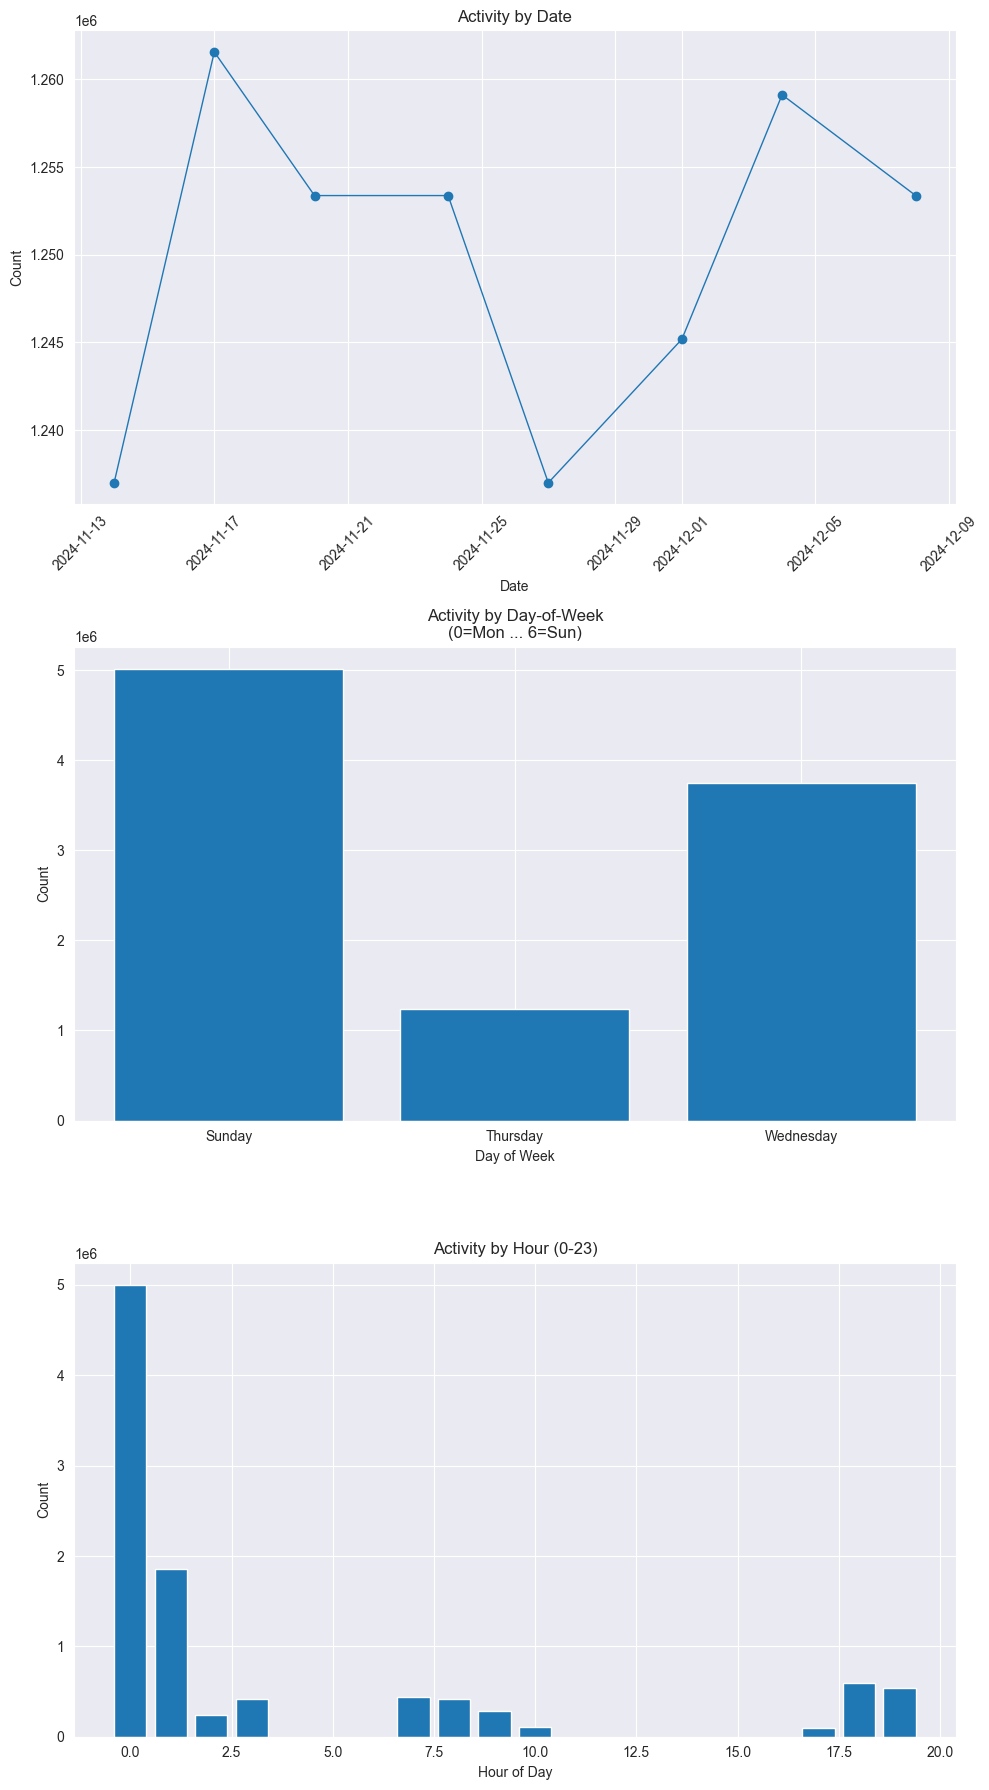

In [5]:
date_counts = {}
dow_counts = {}
hour_counts = {}

num_rows = len(data_df)
current_pos = 0
CHUNK_SIZE = 100000

data_df["happened_at"] = pd.to_datetime(data_df["happened_at"], errors="raise")
data_df = data_df[data_df["happened_at"].dt.year >= 2024]
data_df.reset_index(drop=True, inplace=True)

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
cat_type = pd.CategoricalDtype(categories=ordered_days, ordered=True)

while current_pos < num_rows:
    chunk = data_df.iloc[current_pos : current_pos + CHUNK_SIZE]

    temp = pd.DataFrame()
    temp["date"] = chunk["happened_at"].dt.date
    temp["day_of_week"] = chunk["happened_at"].dt.day_name().astype(cat_type)
    temp["hour"] = chunk["happened_at"].dt.hour  # 0..23

    # --- agg by date ---
    day_group = temp.groupby("date", observed=True).size()
    for day_val, cnt in day_group.items():
        date_counts[day_val] = date_counts.get(day_val, 0) + cnt

    # --- agg by day_of_week ---
    dow_group = temp.groupby("day_of_week", observed=True).size()
    for dow_val, cnt in dow_group.items():
        dow_counts[dow_val] = dow_counts.get(dow_val, 0) + cnt

    # --- agg by hour ---
    hour_group = temp.groupby("hour", observed=True).size()
    for hour_val, cnt in hour_group.items():
        hour_counts[hour_val] = hour_counts.get(hour_val, 0) + cnt

    current_pos += CHUNK_SIZE

df_date_counts = pd.DataFrame(list(date_counts.items()), columns=["date", "count"])
df_date_counts.sort_values("date", inplace=True)

df_dow_counts = pd.DataFrame(list(dow_counts.items()), columns=["day_of_week", "count"])
df_dow_counts.sort_values("day_of_week", inplace=True)

df_hour_counts = pd.DataFrame(list(hour_counts.items()), columns=["hour", "count"])
df_hour_counts.sort_values("hour", inplace=True)

top_active_dates = df_date_counts.sort_values("count", ascending=False).head(10)

print("top 10 active dates:")
print(top_active_dates)

plt.figure(figsize=(10, 18))

# date
plt.subplot(3, 1, 1)
plt.plot(df_date_counts["date"], df_date_counts["count"], marker="o", linewidth=1)
plt.title("Activity by Date")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)

# day-of-week
plt.subplot(3, 1, 2)
plt.bar(df_dow_counts["day_of_week"], df_dow_counts["count"])
plt.title("Activity by Day-of-Week\n(0=Mon ... 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Count")

# hour
plt.subplot(3, 1, 3)
plt.bar(df_hour_counts["hour"], df_hour_counts["count"])
plt.title("Activity by Hour (0-23)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Processes timestamp data to generate a heatmap of event occurrences by date and hour.

C:\Users\matus\AppData\Local\Temp\ipykernel_15904\3824599890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['happened_at'] = pd.to_datetime(data_df['happened_at'], errors='coerce')


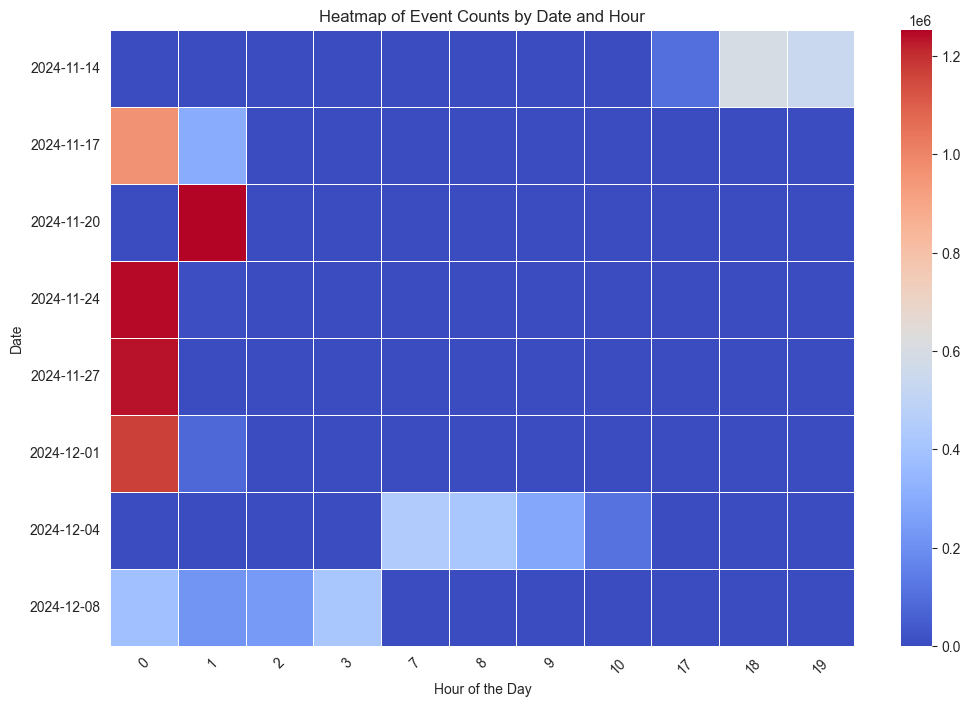

In [6]:
data_df['happened_at'] = pd.to_datetime(data_df['happened_at'], errors='coerce')

data_df = data_df[data_df['happened_at'].dt.year >= 2024]

data_df['date'] = data_df['happened_at'].dt.date
data_df['hour'] = data_df['happened_at'].dt.hour

heatmap_data = data_df.groupby(['date', 'hour']).size().reset_index(name='event_count')

heatmap_pivot = heatmap_data.pivot(index='date', columns='hour', values='event_count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap="coolwarm", linewidths=0.5, annot=False)

plt.xlabel("Hour of the Day")
plt.ylabel("Date")
plt.title("Heatmap of Event Counts by Date and Hour")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Checks if the data is continouos.

In [7]:
data_df["happened_at"] = pd.to_datetime(data_df["happened_at"])
data_df = data_df.sort_values("happened_at")
time_diffs = data_df["happened_at"].diff()

print(time_diffs.describe())
print(time_diffs.value_counts())

df_indexed = data_df.set_index("happened_at")

freq = pd.infer_freq(df_indexed.index)
print(freq)
# rozdelit podla dni, rozdelit na pocet dielikov, x bude cas, y budu kalendarne dni, heat mapa

count                      9999988
mean     0 days 00:00:00.202386242
std      0 days 00:03:59.554512789
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                3 days 23:12:21
Name: happened_at, dtype: object
happened_at
0 days 00:00:00    9955219
0 days 00:00:01      43700
0 days 00:00:02       1017
0 days 00:00:03         42
2 days 04:19:05          1
2 days 23:51:11          1
3 days 22:02:01          1
2 days 22:59:28          1
3 days 23:12:21          1
3 days 06:15:28          1
0 days 00:19:20          1
0 days 00:40:18          1
3 days 13:29:21          1
0 days 00:18:07          1
Name: count, dtype: int64
None


In [9]:
oui_df = pd.read_csv("oui.csv")
data_df

,device,uploaded_file_id,happened_at,rssi,channel,header,payload,id,decoded_headers,frame_control_raw,...,duration_id,destination_mac,source_mac,bssid_mac,sequence_control_raw,fragment_number,sequence_number,frame_body,date,hour
147536,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEEwAFTX4zDSIcx7XCeeMIS4AmZyNCDBAAAmLAAgAAAAALr9,NaN,8950c8c7-0f51-4231-b65f-eb0320cbb3d5,"b""\x88A0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...",16776,...,48,54:d7:e3:30:d2:21,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,49440,0,3090,"b'\x00\x00&,\x00 \x00\x00\x00\x00\xba\xfd'",2024-11-14,17
147518,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-63,1,iEIwAMx7XCeeMFTX4zDSIYS4AmZyNNCnAACJGgAgAAAAAHyP,NaN,8bf9077c-b6ae-4e08-826d-04efa85eba81,"b""\x88B0\x00\xcc{\\'\x9e0T\xd7\xe30\xd2!\x84\x...",17032,...,48,cc:7b:5c:27:9e:30,54:d7:e3:30:d2:21,84:b8:02:66:72:34,42960,0,2685,b'\x00\x00\x89\x1a\x00 \x00\x00\x00\x00|\x8f',2024-11-14,17
147517,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEkwAFTX4zDSIcx7XCeeMIS4AmZyNFDAAAAZLAAgAAAAAACE,NaN,16b54cf4-dce1-454b-962f-1c430f0f5018,"b""\x88I0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...",18824,...,48,54:d7:e3:30:d2:21,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,49232,0,3077,"b'\x00\x00\x19,\x00 \x00\x00\x00\x00\x00\x84'",2024-11-14,17
147516,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEkwAFTX4zDSIcx7XCeeMIS4AmZyNDDAAAAXLAAgAAAAANbZ,NaN,709ba6e4-743a-4bf4-bd9f-eb1e5ade6baa,"b""\x88I0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...",18824,...,48,54:d7:e3:30:d2:21,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,49200,0,3075,"b'\x00\x00\x17,\x00 \x00\x00\x00\x00\xd6\xd9'",2024-11-14,17
147514,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-63,1,iEIwAMx7XCeeMFTX4zDSIYS4AmZyNLCnAACHGgAgAAAAAPKR,NaN,679c4bff-f0f8-41f6-a05a-f932e147860f,"b""\x88B0\x00\xcc{\\'\x9e0T\xd7\xe30\xd2!\x84\x...",17032,...,48,cc:7b:5c:27:9e:30,54:d7:e3:30:d2:21,84:b8:02:66:72:34,42928,0,2683,b'\x00\x00\x87\x1a\x00 \x00\x00\x00\x00\xf2\x91',2024-11-14,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9961378,10:06:1C:86:69:30,2768,2024-12-08 03:55:43,-68,11,gAAAAP///////1TX4yu94lTX4yu94gBdzIes3wgAAABkADEE,AAtKQVNsb3ZlbnNrbwEIgoQLFiQwSGwDAQsFBAABAAAqAQ...,af05c58a-c613-4371-9529-f27f4d02e6bc,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,128,...,0,ff:ff:ff:ff:ff:ff,54:d7:e3:2b:bd:e2,54:d7:e3:2b:bd:e2,23808,0,1488,b'\xcc\x87\xac\xdf\x08\x00\x00\x00d\x001\x04',2024-12-08,3
9961379,10:06:1C:86:69:30,2768,2024-12-08 03:55:43,-69,11,gAAAAP///////1TX4yu941TX4yu94xBdLpGs3wgAAABkADEE,ABBLb25mZXJlbmNpYV8yMDI0AQiChAsWJDBIbAMBCwUEAA...,cb1bcc28-435c-4a2c-a731-85d20a2bb29b,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,128,...,0,ff:ff:ff:ff:ff:ff,54:d7:e3:2b:bd:e3,54:d7:e3:2b:bd:e3,23824,0,1489,b'.\x91\xac\xdf\x08\x00\x00\x00d\x001\x04',2024-12-08,3
9961380,10:06:1C:86:69:30,2768,2024-12-08 03:55:43,-97,11,gAAAAP///////6hb9yCj4qhb9yCj4mD0Y++oWQUAAABkADEE,AAtKQVNsb3ZlbnNrbwEIgoQLFiQwSGwDAQsFBAABAAAqAQ...,6e22953f-db6d-4328-aac6-443a7ab11b6a,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xff\xa8...,128,...,0,ff:ff:ff:ff:ff:ff,a8:5b:f7:20:a3:e2,a8:5b:f7:20:a3:e2,62560,0,3910,b'c\xef\xa8Y\x05\x00\x00\x00d\x001\x04',2024-12-08,3
9961374,10:06:1C:86:69:30,2768,2024-12-08 03:55:43,-92,11,gAAAAP///////1TX4ypZYlTX4ypZYmCTARullAIAAABkADEE,AAtKQVNsb3ZlbnNrbwEIgoQLFiQwSGwDAQsFBAABAAAqAQ...,83da5287-94d6-4737-a4ca-aa7869f3bb22,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,128,...,0,ff:ff:ff:ff:ff:ff,54:d7:e3:2a:59:62,54:d7:e3:2a:59:62,37728,0,2358,b'\x01\x1b\xa5\x94\x02\x00\x00\x00d\x001\x04',2024-12-08,3


Extracts the OUI from MAC addresses and maps them to vendor names based on IEE oui DB.

In [10]:
def process_mac(mac):
    return mac.replace(":", "").upper()[:6]
data_df["OUI"] = data_df["source_mac"].apply(process_mac)

oui_vendor_mapping = dict(zip(oui_df["Assignment"], oui_df["Organization Name"]))
data_df["vendor"] = data_df["OUI"].map(oui_vendor_mapping).fillna("Unknown")
print(data_df[["source_mac", "OUI", "vendor"]].head())


               source_mac     OUI                      vendor
147536  cc:7b:5c:27:9e:30  CC7B5C              Espressif Inc.
147518  54:d7:e3:30:d2:21  54D7E3  Hewlett Packard Enterprise
147517  cc:7b:5c:27:9e:30  CC7B5C              Espressif Inc.
147516  cc:7b:5c:27:9e:30  CC7B5C              Espressif Inc.
147514  54:d7:e3:30:d2:21  54D7E3  Hewlett Packard Enterprise


In [11]:
data_df["vendor"].nunique()

array(['Espressif Inc.', 'Hewlett Packard Enterprise',
       'Samsung Electronics Co.,Ltd', 'Unknown', 'Intel Corporate',
       'Apple, Inc.', 'CLOUD NETWORK TECHNOLOGY SINGAPORE PTE. LTD.',
       'Universal Global Scientific Industrial Co., Ltd.',
       'XEROX CORPORATION', 'Raspberry Pi (Trading) Ltd',
       'SHENZHEN BILIAN ELECTRONIC CO.，LTD',
       'CHONGQING FUGUI ELECTRONICS CO.,LTD.',
       'Xiaomi Communications Co Ltd', 'Liteon Technology Corporation',
       'AzureWave Technology Inc.', 'VMware, Inc.',
       'Nothing Technology Limited',
       'Motorola Mobility LLC, a Lenovo Company',
       'CyberTAN Technology Inc.', 'ALPSALPINE CO,.LTD',
       'Routerboard.com', 'Google, Inc.', 'Raspberry Pi Foundation',
       'Motorola (Wuhan) Mobility Technologies Communication Co., Ltd.',
       'Zhuolian (Shenzhen) Communication Co., Ltd',
       'Tenda Technology Co.,Ltd.Dongguan branch',
       'Raspberry Pi Trading Ltd', 'HUNAN FN-LINK TECHNOLOGY LIMITED',
       'LSD S

vendor
Hewlett Packard Enterprise                                        8593371
Espressif Inc.                                                    1051405
Unknown                                                            234056
CLOUD NETWORK TECHNOLOGY SINGAPORE PTE. LTD.                        25753
Intel Corporate                                                     21495
Tenda Technology Co.,Ltd.Dongguan branch                            19464
Hon Hai Precision Ind. Co.,Ltd.                                      9854
Xiaomi Communications Co Ltd                                         9563
SHENZHEN BILIAN ELECTRONIC CO.，LTD                                   7392
Apple, Inc.                                                          5578
Samsung Electronics Co.,Ltd                                          4606
Raspberry Pi (Trading) Ltd                                           3645
AzureWave Technology Inc.                                            3393
Routerboard.com                

C:\Users\matus\PycharmProjects\BP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


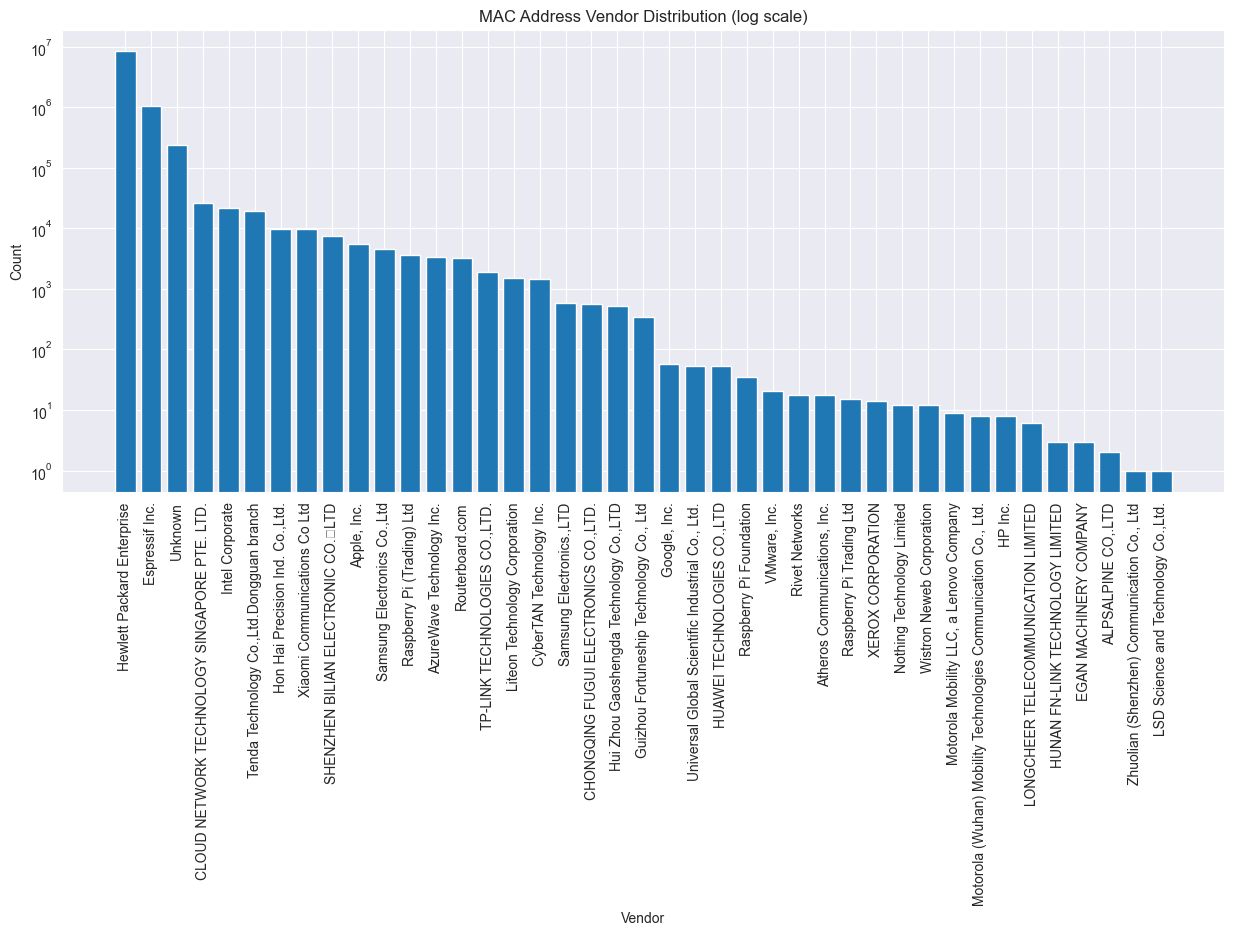

In [21]:
vendor_counts = data_df["vendor"].value_counts()
print(vendor_counts)

plt.figure(figsize=(15, 6))
plt.bar(vendor_counts.index, vendor_counts.values, log=True)
plt.xlabel("Vendor")
plt.ylabel("Count")
plt.title("MAC Address Vendor Distribution (log scale)")
plt.xticks(rotation=90)
plt.show()

In [22]:
data_df.head(500)

,device,uploaded_file_id,happened_at,rssi,channel,header,payload,id,decoded_headers,frame_control_raw,...,source_mac,bssid_mac,sequence_control_raw,fragment_number,sequence_number,frame_body,date,hour,OUI,vendor
147536,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEEwAFTX4zDSIcx7XCeeMIS4AmZyNCDBAAAmLAAgAAAAALr9,NaN,8950c8c7-0f51-4231-b65f-eb0320cbb3d5,"b""\x88A0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...",16776,...,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,49440,0,3090,"b'\x00\x00&,\x00 \x00\x00\x00\x00\xba\xfd'",2024-11-14,17,CC7B5C,Espressif Inc.
147518,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-63,1,iEIwAMx7XCeeMFTX4zDSIYS4AmZyNNCnAACJGgAgAAAAAHyP,NaN,8bf9077c-b6ae-4e08-826d-04efa85eba81,"b""\x88B0\x00\xcc{\\'\x9e0T\xd7\xe30\xd2!\x84\x...",17032,...,54:d7:e3:30:d2:21,84:b8:02:66:72:34,42960,0,2685,b'\x00\x00\x89\x1a\x00 \x00\x00\x00\x00|\x8f',2024-11-14,17,54D7E3,Hewlett Packard Enterprise
147517,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEkwAFTX4zDSIcx7XCeeMIS4AmZyNFDAAAAZLAAgAAAAAACE,NaN,16b54cf4-dce1-454b-962f-1c430f0f5018,"b""\x88I0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...",18824,...,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,49232,0,3077,"b'\x00\x00\x19,\x00 \x00\x00\x00\x00\x00\x84'",2024-11-14,17,CC7B5C,Espressif Inc.
147516,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEkwAFTX4zDSIcx7XCeeMIS4AmZyNDDAAAAXLAAgAAAAANbZ,NaN,709ba6e4-743a-4bf4-bd9f-eb1e5ade6baa,"b""\x88I0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...",18824,...,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,49200,0,3075,"b'\x00\x00\x17,\x00 \x00\x00\x00\x00\xd6\xd9'",2024-11-14,17,CC7B5C,Espressif Inc.
147514,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-63,1,iEIwAMx7XCeeMFTX4zDSIYS4AmZyNLCnAACHGgAgAAAAAPKR,NaN,679c4bff-f0f8-41f6-a05a-f932e147860f,"b""\x88B0\x00\xcc{\\'\x9e0T\xd7\xe30\xd2!\x84\x...",17032,...,54:d7:e3:30:d2:21,84:b8:02:66:72:34,42928,0,2683,b'\x00\x00\x87\x1a\x00 \x00\x00\x00\x00\xf2\x91',2024-11-14,17,54D7E3,Hewlett Packard Enterprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147896,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:49,-72,6,UAg6Ab4JDp9uIUaBsoZmSEaBsoZmSOAdzsxc4TxsiwBkABEV,AA9pUGhvbmUgKE1hcnluYSkBCIKEi5YkMEhsAwEGBwZTSy...,7614ad19-32cc-4bbc-8cd7-68b557992ccc,b'P\x08:\x01\xbe\t\x0e\x9fn!F\x81\xb2\x86fHF\x...,2128,...,46:81:b2:86:66:48,46:81:b2:86:66:48,7648,0,478,b'\xce\xcc\\\xe1<l\x8b\x00d\x00\x11\x15',2024-11-14,17,4681B2,Unknown
147895,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:49,-78,6,UAA6Ab4JDp9uIUaBsoZmSEaBsoZmSOAdfMNc4TxsiwBkABEV,AA9pUGhvbmUgKE1hcnluYSkBCIKEi5YkMEhsAwEGBwZTSy...,3be88b7e-272d-4f05-878e-545d6636350b,b'P\x00:\x01\xbe\t\x0e\x9fn!F\x81\xb2\x86fHF\x...,80,...,46:81:b2:86:66:48,46:81:b2:86:66:48,7648,0,478,b'|\xc3\\\xe1<l\x8b\x00d\x00\x11\x15',2024-11-14,17,4681B2,Unknown
147894,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:49,-71,6,QAAAAP///////74JDp9uIf///////wDHAAABCAIECxYMEhgk,MgQwSGBsAwEGLRotARf/AAAAAAAAAAAAAAAAAAAAAAAAAA...,a7d94d13-4e2a-4d17-9791-20bb96be7a5a,b'@\x00\x00\x00\xff\xff\xff\xff\xff\xff\xbe\t\...,64,...,be:09:0e:9f:6e:21,ff:ff:ff:ff:ff:ff,50944,0,3184,b'\x00\x00\x01\x08\x02\x04\x0b\x16\x0c\x12\x18$',2024-11-14,17,BE090E,Unknown
147893,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:49,-63,6,CEIAAAEAXgAA+1TX4y6mgXrJf25WrFBhHRcAYGEAAAAomBlK,NaN,de67c629-d7a0-470d-8bc7-5641cde47d1f,b'\x08B\x00\x00\x01\x00^\x00\x00\xfbT\xd7\xe3....,16904,...,54:d7:e3:2e:a6:81,7a:c9:7f:6e:56:ac,24912,0,1557,b'\x1d\x17\x00`a\x00\x00\x00(\x98\x19J',2024-11-14,17,54D7E3,Hewlett Packard Enterprise
